In [ ]:
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor
import logging
from datasets import load_dataset
import pyarrow as pa
import pyarrow.parquet as pq
import concurrent.futures
from tqdm import tqdm
import logging


from datasets import load_dataset
from tqdm import tqdm


dataset = load_dataset(
  "HuggingFaceM4/OBELICS", 
  cache_dir="/home/ajay.meena/obelics/huggiface_cache", 
  split='train',
)


Resolving data files:   0%|          | 0/1432 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1432 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/1439 [00:00<?, ?it/s]

[None,
 'https://slidelegend.com/img/60x80/management-factors-influencing-open-innovation-div_59c212ac1723dd1242167485.jpg',
 None]

In [23]:
print(dataset[2]['images'])
print(dataset[2]['metadata'])
print(dataset[2]['general_metadata'])

[None, 'https://slidelegend.com/img/60x80/management-factors-influencing-open-innovation-div_59c212ac1723dd1242167485.jpg', None]
[null, {"document_url": "https://slidelegend.com/the-influencing-factors-on-entrepreneurship-ti-journals_59d9b3c91723dd4b8ead833e.html", "unformatted_src": "https://slidelegend.com/img/60x80/management-factors-influencing-open-innovation-div_59c212ac1723dd1242167485.jpg", "src": "https://slidelegend.com/img/60x80/management-factors-influencing-open-innovation-div_59c212ac1723dd1242167485.jpg", "formatted_filename": "management factors influencing open innovation div c ac dd", "rendered_width": 626, "original_width": 626, "original_height": 626, "format": "jpeg"}, null]
{"url": "https://slidelegend.com/the-influencing-factors-on-entrepreneurship-ti-journals_59d9b3c91723dd4b8ead833e.html", "warc_filename": "crawl-data/CC-MAIN-2020-24/segments/1590347392057.6/warc/CC-MAIN-20200527013445-20200527043445-00580.warc.gz", "warc_record_offset": 536988620, "warc_recor

In [18]:
print([(i, len(dataset[i]['images'])) for i in range(0,1000)])

sum([1 for i in range(0,1000) if len(dataset[i]['images']) <= 3 ])

[(0, 2), (1, 2), (2, 3), (3, 5), (4, 2), (5, 2), (6, 2), (7, 5), (8, 2), (9, 3), (10, 2), (11, 2), (12, 7), (13, 3), (14, 2), (15, 4), (16, 44), (17, 3), (18, 10), (19, 2), (20, 7), (21, 12), (22, 2), (23, 3), (24, 9), (25, 4), (26, 2), (27, 2), (28, 2), (29, 2), (30, 19), (31, 3), (32, 2), (33, 2), (34, 3), (35, 7), (36, 2), (37, 2), (38, 5), (39, 5), (40, 3), (41, 3), (42, 7), (43, 8), (44, 3), (45, 2), (46, 2), (47, 2), (48, 2), (49, 2), (50, 7), (51, 5), (52, 2), (53, 2), (54, 2), (55, 2), (56, 5), (57, 2), (58, 3), (59, 3), (60, 3), (61, 3), (62, 2), (63, 7), (64, 4), (65, 5), (66, 12), (67, 15), (68, 2), (69, 6), (70, 5), (71, 3), (72, 3), (73, 3), (74, 4), (75, 5), (76, 2), (77, 4), (78, 3), (79, 2), (80, 13), (81, 7), (82, 3), (83, 3), (84, 7), (85, 2), (86, 3), (87, 2), (88, 9), (89, 6), (90, 2), (91, 3), (92, 3), (93, 3), (94, 3), (95, 5), (96, 2), (97, 2), (98, 2), (99, 3), (100, 2), (101, 7), (102, 5), (103, 2), (104, 2), (105, 2), (106, 2), (107, 3), (108, 3), (109, 4), (1

607

In [21]:
dataset[3]['images']
dataset

Dataset({
    features: ['images', 'metadata', 'general_metadata', 'texts'],
    num_rows: 141047697
})

In [2]:
from datasets import Dataset
dataset = Dataset.from_file("obelics-train-00000-of-01439.arrow")
dataset

Dataset({
    features: ['images', 'metadata', 'general_metadata', 'texts'],
    num_rows: 97000
})

In [7]:
import datasets
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image
import requests
from io import BytesIO
import tqdm

# Step 1: Load your dataset
# Replace 'your_dataset_name' and 'your_split' with your actual dataset name and split

# Optional: Define the number of threads based on your system's capabilities
MAX_WORKERS = 10  # Adjust this number as needed

# Step 2: Define a function to fetch a single image from a URL
def fetch_image(url):
    if url is None:
        return None
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        # Optionally, convert image to a desired format (e.g., RGB)
        img = img.convert('RGB')
        return img
    except Exception as e:
        print(f"Failed to fetch image from {url}: {e}")
        return None

# Step 3: Define a function to process a list of URLs for each row
def process_image_list(image_list):
    if not isinstance(image_list, list):
        return None
    # Prepare to collect results with their indices
    idx_url_pairs = [(idx, url) for idx, url in enumerate(image_list) if url is not None]
    results = [None] * len(image_list)
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_idx = {executor.submit(fetch_image, url): idx for idx, url in idx_url_pairs}
        for future in as_completed(future_to_idx):
            idx = future_to_idx[future]
            try:
                results[idx] = future.result()
            except Exception as e:
                print(f"Failed to process image at index {idx}: {e}")
                results[idx] = None
    return results

# Step 4: Define a function to process a batch of data
def process_batch(batch):
    # Process each 'images' list in the batch
    batch_size = len(batch['images'])
    processed_images = [None] * batch_size
    # Use ThreadPoolExecutor for multithreading across rows
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_idx = {
            executor.submit(process_image_list, batch['images'][idx]): idx
            for idx in range(batch_size)
        }
        for future in tqdm.tqdm(as_completed(future_to_idx), total=batch_size, desc="Processing batch"):
            idx = future_to_idx[future]
            try:
                processed_images[idx] = future.result()
            except Exception as e:
                print(f"Failed to process images in row {idx}: {e}")
                processed_images[idx] = [None] * len(batch['images'][idx])
    # Update the batch with the processed images
    return processed_images

# Step 5: Process the dataset in batches and update it
# Adjust batch_size according to your memory constraints
BATCH_SIZE = 100  # Adjust this number as needed

# Use tqdm for progress bar
for i in tqdm.tqdm(range(0, len(dataset), BATCH_SIZE), desc="Processing dataset"):
    batch_indices = range(i, min(i + BATCH_SIZE, len(dataset)))
    batch = dataset.select(batch_indices)
    processed_batch = process_batch(batch)

    # Replace the old batch with the processed batch
    dataset = dataset.map(
        lambda example, idx: {
            'images': processed_batch[idx - i]
        } if idx in batch_indices else example,
        with_indices=True,
        load_from_cache_file=False,
        desc="Updating dataset"
    )


# Optional: Save the processed dataset to disk
dataset.save_to_disk('processed_dataset')


Processing dataset:   0%|          | 0/970 [00:00<?, ?it/s]

Failed to fetch image from https://eppc.org/wp-content/uploads/2017/07/shutterstock_636139745-1024x683.jpg: 403 Client Error: Forbidden for url: https://eppc.org/wp-content/uploads/2017/07/shutterstock_636139745-1024x683.jpg
Failed to fetch image from https://www.debate.com.mx/__export/1631449386230/sites/debate/img/2021/09/12/turistas-mazatlan-2.jpg_1187572215.jpg: 403 Client Error: Forbidden for url: https://www.debate.com.mx/__export/1631449386230/sites/debate/img/2021/09/12/turistas-mazatlan-2.jpg_1187572215.jpg


Failed to fetch image from https://vidmid.com/upload/news/image_1611340213_9962819.jpg: 404 Client Error: Not Found for url: https://vidmid.com/upload/news/image_1611340213_9962819.jpg
Failed to fetch image from https://www.henryusa.com/wp-content/uploads/2021/06/kalel_1200px-480x480.jpg: 403 Client Error: Forbidden for url: https://www.henryusa.com/wp-content/uploads/2021/06/kalel_1200px-480x480.jpg
Failed to fetch image from https://vidmid.com/upload/news/image_1611349240_58992742.jpeg: 404 Client Error: Not Found for url: https://vidmid.com/upload/news/image_1611349240_58992742.jpeg
Failed to fetch image from https://vidmid.com/upload/news/image_1607022019_96572726.jpg: 404 Client Error: Not Found for url: https://vidmid.com/upload/news/image_1607022019_96572726.jpg
Failed to fetch image from https://vidmid.com/upload/news/image_1607022020_15618687.jpg: 404 Client Error: Not Found for url: https://vidmid.com/upload/news/image_1607022020_15618687.jpg
Failed to fetch image from https:

Failed to fetch image from https://ionigeria.com/wp-content/uploads/2021/12/James-Webb-323x330.jpg: HTTPSConnectionPool(host='ionigeria.com', port=443): Max retries exceeded with url: /wp-content/uploads/2021/12/James-Webb-323x330.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)')))
Failed to fetch image from https://vidmid.com/upload/news/image_1607022018_86288425.jpg: 404 Client Error: Not Found for url: https://vidmid.com/upload/news/image_1607022018_86288425.jpg


Failed to fetch image from http://cdn.shopify.com/s/files/1/0025/8002/1309/t/75/assets/popup-header-image_490x.jpg?v=143601077120798896961671709859: 404 Client Error: Not Found for url: https://cdn.shopify.com/s/files/1/0025/8002/1309/t/75/assets/popup-header-image_490x.jpg?v=143601077120798896961671709859
Failed to fetch image from https://www.zwillgen.com/wp-content/uploads/2022/05/AdobeStock_394300808-960x540.jpeg: 403 Client Error: Forbidden for url: https://www.zwillgen.com/wp-content/uploads/2022/05/AdobeStock_394300808-960x540.jpeg


Failed to fetch image from https://worldnews.su/wp-content/uploads/2022/06/db13846c370fcf02fadf1c37d160d76c.jpg: HTTPSConnectionPool(host='worldnews.su', port=443): Max retries exceeded with url: /wp-content/uploads/2022/06/db13846c370fcf02fadf1c37d160d76c.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1000)')))


Failed to fetch image from https://static.timesofisrael.com/jewishndev/uploads/2021/04/AN4T7158-640x400.jpg: 403 Client Error: Forbidden for url: https://static.timesofisrael.com/jewishndev/uploads/2021/04/AN4T7158-640x400.jpg
Failed to fetch image from http://archiveislam.com/wp-content/uploads/2013/01/muslim-snow-patrol.jpg: 403 Client Error: Forbidden for url: http://archiveislam.com/wp-content/uploads/2013/01/muslim-snow-patrol.jpg
Failed to fetch image from http://archiveislam.com/wp-content/uploads/2013/01/muslim-neighbour.jpg: 403 Client Error: Forbidden for url: http://archiveislam.com/wp-content/uploads/2013/01/muslim-neighbour.jpg
Failed to fetch image from http://archiveislam.com/wp-content/uploads/2013/01/harvard-university-quran.jpg: 403 Client Error: Forbidden for url: http://archiveislam.com/wp-content/uploads/2013/01/harvard-university-quran.jpg
Failed to fetch image from http://archiveislam.com/wp-content/uploads/2013/08/eid-google.jpg: 403 Client Error: Forbidden for 

Failed to fetch image from http://cmt.mtvnimages.com/uri/mgid:uma:image:cmt.com:1647334?quality=0.8&format=jpg&height=495&width=660: HTTPConnectionPool(host='cmt.mtvnimages.com', port=80): Max retries exceeded with url: /uri/mgid:uma:image:cmt.com:1647334?quality=0.8&format=jpg&height=495&width=660 (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7c9e6d5aee10>: Failed to resolve 'cmt.mtvnimages.com' ([Errno -5] No address associated with hostname)"))
Failed to fetch image from http://realdealtheatre.webs.com/WestEnd%20Xtra%201.jpg: HTTPConnectionPool(host='realdealtheatre.webs.com', port=80): Max retries exceeded with url: /WestEnd%20Xtra%201.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7c9e6d5ac2c0>: Failed to resolve 'realdealtheatre.webs.com' ([Errno -2] Name or service not known)"))
Failed to fetch image from http://realdealtheatre.webs.com/West%20End%20Extra%20Sitcom%20Saturday.jpg: HTTPConnectionPool(host='realde

Failed to fetch image from https://holaamericanews.com/wp-content/uploads/2018/01/Carmona-1-150x150.jpg: 403 Client Error: Forbidden for url: https://holaamericanews.com/wp-content/uploads/2018/01/Carmona-1-150x150.jpg
Failed to fetch image from https://holaamericanews.com/wp-content/uploads/2018/01/optimized-to-my-bros-696x522.jpg: 403 Client Error: Forbidden for url: https://holaamericanews.com/wp-content/uploads/2018/01/optimized-to-my-bros-696x522.jpg
Failed to fetch image from https://www.nationalhogfarmer.com/sites/nationalhogfarmer.com/files/styles/article_featured_standard/public/NHF-pigsbarns_2.jpg?itok=dAtEUiHd: 404 Client Error: Not Found for url: https://www.nationalhogfarmer.com/sites/nationalhogfarmer.com/files/styles/article_featured_standard/public/NHF-pigsbarns_2.jpg?itok=dAtEUiHd
Failed to fetch image from https://www.nationalhogfarmer.com/sites/cet.com/files/Plain%20graphic%201%2010.21.png: 404 Client Error: Not Found for url: https://www.nationalhogfarmer.com/sites/

Failed to fetch image from https://www.nationalhogfarmer.com/sites/cet.com/files/plain%20graphic%206%2010.21.png: 404 Client Error: Not Found for url: https://www.nationalhogfarmer.com/sites/cet.com/files/plain%20graphic%206%2010.21.png


Failed to fetch image from https://newcanaanlandtrust.org/wp-content/uploads/2019/03/hannan-7-400x284.png: 403 Client Error: Forbidden for url: https://newcanaanlandtrust.org/wp-content/uploads/2019/03/hannan-7-400x284.png
Failed to fetch image from https://newcanaanlandtrust.org/wp-content/uploads/2019/03/hannan-9-400x284.png: 403 Client Error: Forbidden for url: https://newcanaanlandtrust.org/wp-content/uploads/2019/03/hannan-9-400x284.png


Failed to fetch image from https://v5.femalefirst.co.uk/image-library/partners/bang/land/1000/e/eddie-redmayne-aW1hZ2VzMS8yMDE4LzExLzE0LzAwNTM2NDAwMDE1NDIxO.jpg: HTTPSConnectionPool(host='v5.femalefirst.co.uk', port=443): Max retries exceeded with url: /image-library/partners/bang/land/1000/e/eddie-redmayne-aW1hZ2VzMS8yMDE4LzExLzE0LzAwNTM2NDAwMDE1NDIxO.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c9e6dff8800>: Failed to resolve 'v5.femalefirst.co.uk' ([Errno -2] Name or service not known)"))
Failed to fetch image from https://v5.femalefirst.co.uk/image-library/partners/bang/land/250/a/annie-wallace-aW1hZ2VzMS8yMDIxLzA2LzExLzE2MjM0MTAyMjBjcm9wcG.jpg: HTTPSConnectionPool(host='v5.femalefirst.co.uk', port=443): Max retries exceeded with url: /image-library/partners/bang/land/250/a/annie-wallace-aW1hZ2VzMS8yMDIxLzA2LzExLzE2MjM0MTAyMjBjcm9wcG.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c9e6dfa0920>: Failed to r

Failed to fetch image from http://phototass4.cdnvideo.ru/width/1020_b9261fa1/tass/m2/en/uploads/i/20181001/1204153.jpg: HTTPConnectionPool(host='phototass4.cdnvideo.ru', port=80): Max retries exceeded with url: /width/1020_b9261fa1/tass/m2/en/uploads/i/20181001/1204153.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x7c9e6d570560>: Failed to resolve 'phototass4.cdnvideo.ru' ([Errno -2] Name or service not known)"))


Failed to fetch image from https://www.betarena.com/wp-content/uploads/2020/02/Leon-1-370x305.jpg: 404 Client Error: Not Found for url: https://www.betarena.com/wp-content/uploads/2020/02/Leon-1-370x305.jpg
Failed to fetch image from https://www.saturdayeveningpost.com/wp-content/uploads/satevepost/2017-so-pg18-motherdaughter.jpg: 403 Client Error: Forbidden for url: https://www.saturdayeveningpost.com/wp-content/uploads/satevepost/2017-so-pg18-motherdaughter.jpg
Failed to fetch image from https://www.betarena.com/wp-content/uploads/2020/02/AEK-300x169.jpeg: 404 Client Error: Not Found for url: https://www.betarena.com/wp-content/uploads/2020/02/AEK-300x169.jpeg
Failed to fetch image from https://www.betarena.com/wp-content/uploads/2020/02/Aris-370x305.jpg: 404 Client Error: Not Found for url: https://www.betarena.com/wp-content/uploads/2020/02/Aris-370x305.jpg


Failed to fetch image from https://www.betarena.com/wp-content/uploads/elementor/thumbs/Atlanta-United-vs-Montreal-Impact-Betting-Tip-and-Prediction-oedudyfgljiufdvu3gvnjqo22e10pz8bi28wikjrcs.jpg: 404 Client Error: Not Found for url: https://www.betarena.com/wp-content/uploads/elementor/thumbs/Atlanta-United-vs-Montreal-Impact-Betting-Tip-and-Prediction-oedudyfgljiufdvu3gvnjqo22e10pz8bi28wikjrcs.jpg
Failed to fetch image from https://www.betarena.com/wp-content/uploads/2020/01/pngfuel.com_.png: 404 Client Error: Not Found for url: https://www.betarena.com/wp-content/uploads/2020/01/pngfuel.com_.png


Processing batch: 100%|██████████| 100/100 [00:06<00:00, 15.43it/s]


Updating dataset:   0%|          | 0/97000 [00:00<?, ? examples/s]

Processing dataset:   0%|          | 0/970 [02:41<?, ?it/s]


ArrowInvalid: cannot mix struct and non-struct, non-null values

In [ ]:
import datasets
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image
import requests
from io import BytesIO
import tqdm

# Load your dataset

# Define the number of threads based on your system's capabilities
MAX_WORKERS = 50

# Function to fetch a single image
def fetch_image(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')
        return img
    except Exception as e:
        return None

# Function to process a list of URLs
def process_image_list(image_list):
    idx_url_pairs = [(idx, url) for idx, url in enumerate(image_list) if url is not None]
    results = [None] * len(image_list)
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_idx = {executor.submit(fetch_image, url): idx for idx, url in idx_url_pairs}
        for future in as_completed(future_to_idx):
            idx = future_to_idx[future]
            results[idx] = future.result() if future.exception() is None else None
    return results

# Function to process a batch of data
def process_batch(batch):
    batch_size = len(batch['images'])
    processed_images = [process_image_list(images) for images in batch['images']]
    return {'images': processed_images}

# Apply the processing using the map function with batched processing
def update_dataset(batch):
    processed_batch = process_batch(batch)
    return {'images': processed_batch['images']}

dataset = dataset.map(update_dataset, batched=True, batch_size=500)

# Save the processed dataset to disk
dataset.save_to_disk('processed_dataset')


Map:   0%|          | 0/97000 [00:00<?, ? examples/s]

In [1]:
from datasets import load_from_disk

dataset = load_from_disk('processed_dataset')


Loading dataset from disk:   0%|          | 0/242 [00:00<?, ?it/s]

In [17]:
# dataset[2]['metadata']
# dataset[2]['general_metadata']
# dataset[2]
dataset

Dataset({
    features: ['images', 'metadata', 'general_metadata', 'texts'],
    num_rows: 97000
})

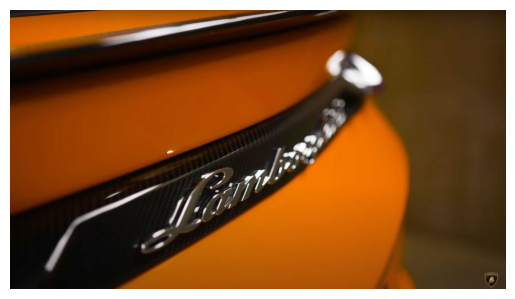

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Function to display an image from dataset bytes
def display_image(image_bytes):
    try:
        img = Image.open(BytesIO(image_bytes))
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
    except Exception as e:
        print(f"Error displaying image: {e}")

# Example: Display the first image in the dataset
image_data = dataset[1]['images'][0]['bytes']
# display_image(image_data)

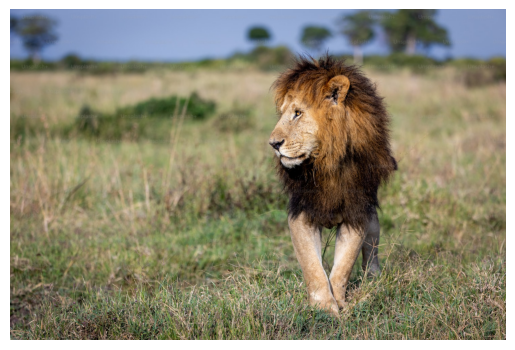

In [12]:
import requests
from io import BytesIO

def fetch_image_bytes(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return response.content  # Directly return raw bytes without processing
    except Exception as e:
        print(f"Error fetching image: {e}")
        return None

def fetch_image(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        
        # Convert to RGBA if the image has a transparency channel, otherwise use RGB
        if img.mode in ('RGBA', 'LA') or ('transparency' in img.info):
            img = img.convert('RGBA')
        else:
            img = img.convert('RGB')
        
        return img
    except Exception as e:
        print(f"Error fetching image: {e}")
        return None


url = """https://plus.unsplash.com/premium_photo-1666672388644-2d99f3feb9f1?q=80&w=1470&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"""

display_image(fetch_image_bytes(url))
# fetch_image(url)